In [1]:
from rbi.models import InverseAffineAutoregressiveModel
from rbi.loss import NLLLoss

from rbibm.tasks import HHTask
from rbibm.tasks.hh_task import SimpleHHTask
import torch 
from torch import nn

import matplotlib.pyplot as plt

seed = 0
torch.manual_seed(seed)

In [2]:
colors = ["#08519c", "#d94801"]

In [3]:
task = SimpleHHTask()
prior = task.get_prior()
simulator = task.get_simulator()
train_loader, _,_ = task.get_train_test_val_dataset(10000,0,0)

In [4]:
model = InverseAffineAutoregressiveModel(task.input_dim, task.output_dim, output_transform=torch.distributions.biject_to(prior.support), num_transforms=3, embedding_net=nn.Sequential(nn.Linear(500,200), nn.ReLU(),nn.Linear(200, 200), nn.ReLU(), nn.Linear(200, 50), nn.ReLU()), hidden_dims=[100,100])
loss_fn = NLLLoss(model)

In [12]:
assert torch.__version__ == '1.13.0+cu116', "This notebook unfortunatly requires 1.13.0, for reproduction..."

'1.13.1'

In [5]:
num_epochs = 40
optim = torch.optim.Adam(model.parameters())
for i in range(num_epochs):
    for x, theta in train_loader:
        optim.zero_grad()
        l = loss_fn(x, theta)
        l.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 10.)
        optim.step()
    print(l)

tensor([9.5626], grad_fn=<AddBackward0>)
tensor([8.7217], grad_fn=<AddBackward0>)
tensor([8.2708], grad_fn=<AddBackward0>)
tensor([7.0430], grad_fn=<AddBackward0>)
tensor([7.1494], grad_fn=<AddBackward0>)
tensor([10.1534], grad_fn=<AddBackward0>)
tensor([6.6230], grad_fn=<AddBackward0>)
tensor([8.1110], grad_fn=<AddBackward0>)
tensor([6.2140], grad_fn=<AddBackward0>)
tensor([6.1788], grad_fn=<AddBackward0>)
tensor([6.2966], grad_fn=<AddBackward0>)
tensor([5.7146], grad_fn=<AddBackward0>)
tensor([5.9189], grad_fn=<AddBackward0>)
tensor([5.8401], grad_fn=<AddBackward0>)
tensor([5.1591], grad_fn=<AddBackward0>)
tensor([5.6291], grad_fn=<AddBackward0>)
tensor([5.2698], grad_fn=<AddBackward0>)
tensor([5.1893], grad_fn=<AddBackward0>)
tensor([5.2397], grad_fn=<AddBackward0>)
tensor([6.2708], grad_fn=<AddBackward0>)
tensor([5.6623], grad_fn=<AddBackward0>)
tensor([4.9224], grad_fn=<AddBackward0>)
tensor([5.1083], grad_fn=<AddBackward0>)
tensor([5.4735], grad_fn=<AddBackward0>)
tensor([5.2836]

In [6]:
torch.manual_seed(seed + 1)

In [7]:
thetas = prior.sample((1000,))
xs = simulator(thetas)

In [8]:
from rbibm.metric.robustness_metric import ReverseKLRobMetric, ReverseKLLoss
from rbi.attacks import LinfPGDAdamAttack

In [9]:
attack = LinfPGDAdamAttack(model, ReverseKLLoss(mc_samples=5), eps=3., eps_iter=0.1, nb_iter=200)

In [10]:
m = ReverseKLRobMetric(model, attack)

In [11]:
m.eval(xs.contiguous())

tensor(13.2582)

In [41]:
x_idx, x_o_tilde = m.generate_adversarial_examples(xs)

In [32]:
x_o = xs[x_idx[16]].unsqueeze(0)
theta = thetas[x_idx[16]].unsqueeze(0)

In [31]:
# for i in range(100):
#     print(i)
#     plt.plot(xs[i])
#     plt.show()

In [42]:
x_o_tilde= x_o_tilde[16].unsqueeze(0)

In [43]:
from sbi.analysis import pairplot

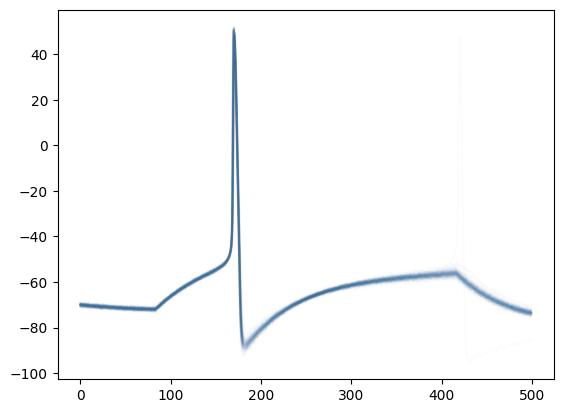

In [44]:
with torch.no_grad():
    q = model(x_o)
_ = plt.plot(simulator(q.sample((100,)).squeeze()).squeeze().T, color=colors[0], alpha=0.01)

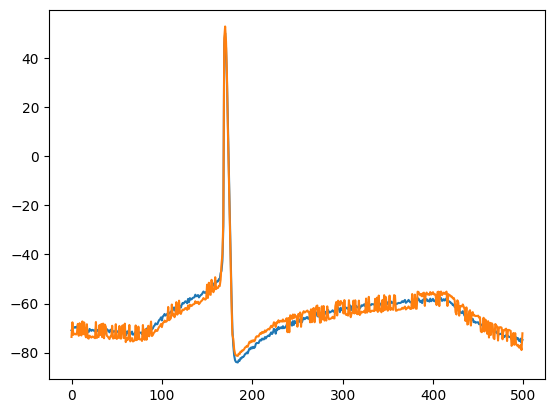

In [45]:
plt.plot(x_o.T)
_ = plt.plot(x_o_tilde[0].T)

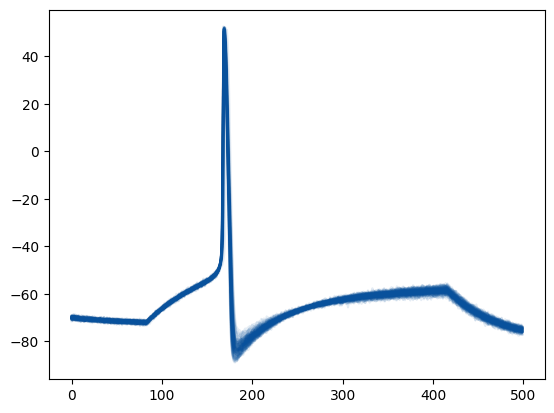

In [46]:
_ = plt.plot(simulator(model(x_o_tilde[0].squeeze()).sample((100,))).detach().T, color=colors[0], alpha=0.1)

In [19]:
delta = x_o_tilde -x_o

c:\ProgramData\Miniconda3\lib\site-packages\torch\functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\TensorShape.cpp:3191.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


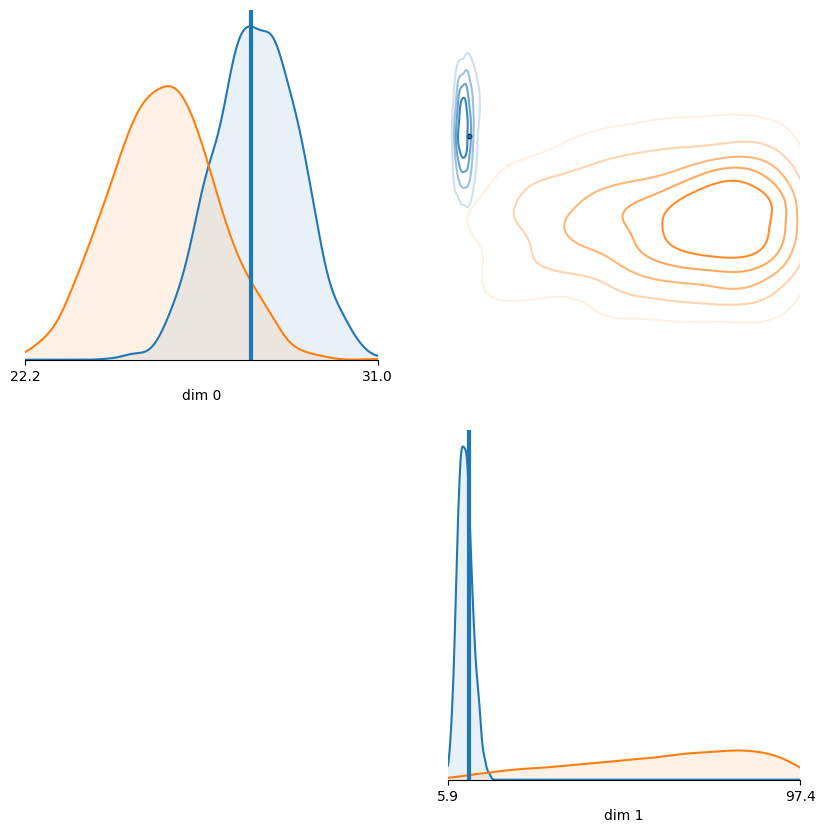

In [20]:
from rbibm.plots.custom_distribution_plots import custom_pairplot, custom_2d_joint_plot
from rbibm.plots.styles import use_style
q = model(x_o)
q_tilde = model(x_o_tilde[0])

_ = custom_pairplot([q.sample((2000,)).squeeze(), q_tilde.sample((2000,)).squeeze()], points=[theta], bins=200)

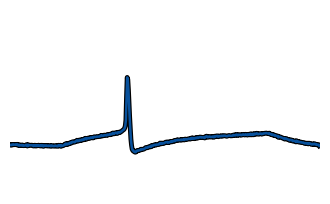

In [21]:
import matplotlib.patheffects as pe

fig = plt.figure(figsize=(4, 2.4))
_ = plt.plot(x_o.T, color=colors[0],lw=1.8,path_effects=[pe.Stroke(linewidth=3.5, foreground='black'), pe.Normal()])
plt.ylim(-150, 150)
plt.xlim(0, 500)
plt.axis("off")
fig.savefig("x.svg", transparent=True)

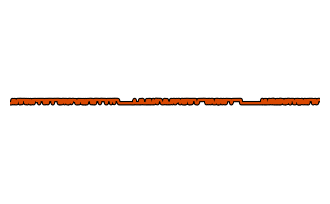

In [22]:
import matplotlib.patheffects as pe
from matplotlib.colors import to_rgb

fig = plt.figure(figsize=(4, 2.4))
_ = plt.plot(delta.T, color=colors[1],lw=1.6,path_effects=[pe.Stroke(linewidth=3.2, foreground='black'), pe.Normal()])
plt.ylim(-150, 150)
plt.xlim(0, 500)
plt.axis("off")
fig.savefig("delta.svg", transparent=True)

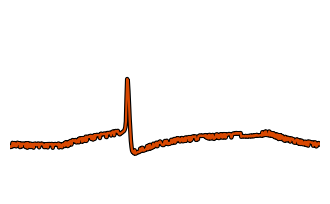

In [23]:
import matplotlib.patheffects as pe
import numpy as np
from matplotlib.colors import to_hex

c = colors[1]

fig = plt.figure(figsize=(4, 2.4))
_ = plt.plot(x_o_tilde.T, color=c,lw=1.6,path_effects=[pe.Stroke(linewidth=3.2, foreground='black'), pe.Normal()])
plt.ylim(-150, 150)
plt.xlim(0, 500)
plt.axis("off")
fig.savefig("x_tilde.svg", transparent=True)

In [24]:
torch.manual_seed(seed + 4)

In [25]:
q = model(x_o)

In [26]:
samples = q.sample((50000,))

In [27]:
import matplotlib as mpl 

C:\Users\manug\AppData\Local\Temp\ipykernel_10620\1515675248.py:18: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "bbox" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.savefig("post.svg", bbox="tight", transparent=True)


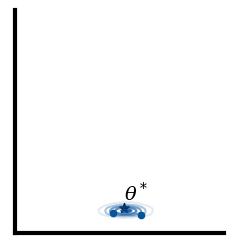

In [28]:
with use_style("pyloric"):
    mpl.rcParams["axes.linewidth"]=3
    fig, axes = custom_2d_joint_plot([samples.squeeze(),],dim1=0, figsize=(3.25,3.5), dim2=1, bins=200,ylim=[0,100], xlim=[20,35], labels=["$\\theta_1$", "$\\theta_2$"], colors=colors)
    sample1 = q.sample()
    sample2 = q.sample()
    axes[0].scatter(theta[:, 0], theta[:, 1],color="black", marker="*", s=50.)
    axes[0].text(theta[:, 0], theta[:, 1] + 3, "$\\theta^*$", fontsize=14)

    axes[0].scatter(sample1[:,0], sample1[:,1], s=20., color=colors[0])
    axes[0].scatter(sample2[:,0], sample2[:,1], s=20., color=colors[0])
    axes[0].set_xticks([])
    axes[0].set_yticks([])
    fig.delaxes(axes[1])
    fig.delaxes(axes[2])
    axes[0].set_ylabel("")
    axes[0].set_xlabel("")

fig.savefig("post.svg", bbox="tight", transparent=True)

In [29]:
x_pred1 = simulator(sample1)
x_pred2 = simulator(sample2)

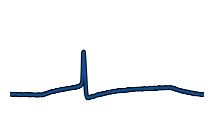

In [30]:
import matplotlib.patheffects as pe

fig = plt.figure(figsize=(2.5, 1.5))
_ = plt.plot(x_pred1.T, color=colors[0],lw=1.6,path_effects=[pe.Stroke(linewidth=3.2, foreground='black'), pe.Normal()])
plt.ylim(-150, 150)
plt.xlim(0, 500)
plt.axis("off")
fig.savefig("x_pred1.svg", transparent=True)

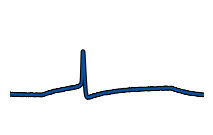

In [31]:
import matplotlib.patheffects as pe

fig = plt.figure(figsize=(2.5, 1.5))
_ = plt.plot(x_pred2.T, color=colors[0],lw=1.6,path_effects=[pe.Stroke(linewidth=3.2, foreground='black'), pe.Normal()])
plt.ylim(-150, 150)
plt.xlim(0, 500)
plt.axis("off")
fig.savefig("x_pred2.svg", transparent=True)

In [32]:
q = model(x_o_tilde)
samples = q.sample((50000,))

In [33]:
from matplotlib.colors import to_hex

In [34]:
torch.manual_seed(seed+8)

C:\Users\manug\AppData\Local\Temp\ipykernel_10620\2071691215.py:18: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "bbox" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.savefig("adversarial_post.svg", bbox="tight", transparent=True)


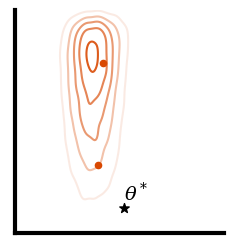

In [35]:
with use_style("pyloric"):
    mpl.rcParams["axes.linewidth"]=3
    fig, axes = custom_2d_joint_plot([samples.squeeze(),],dim1=0, dim2=1,figsize=(3.25,3.5), bins=200,ylim=[0,100], xlim=[20,35], labels=["$\\theta_1$", "$\\theta_2$"], colors=[c])
    sample1 = q.sample()
    sample2 = q.sample()
    axes[0].scatter(theta[:, 0], theta[:, 1],color="black", marker="*", s=50.)
    axes[0].text(theta[:, 0], theta[:, 1] + 3, "$\\theta^*$", fontsize=14)

    axes[0].scatter(sample1[:,0], sample1[:,1], s=20., color=c)
    axes[0].scatter(sample2[:,0], sample2[:,1], s=20., color=c)
    axes[0].set_xticks([])
    axes[0].set_yticks([])
    fig.delaxes(axes[1])
    fig.delaxes(axes[2])
    axes[0].set_ylabel("")
    axes[0].set_xlabel("")

fig.savefig("adversarial_post.svg", bbox="tight", transparent=True)

In [36]:
x_pred1 = simulator(sample1)
x_pred2 = simulator(sample2)

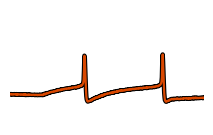

In [37]:
import matplotlib.patheffects as pe

fig = plt.figure(figsize=(2.5, 1.5))
_ = plt.plot(x_pred1.T, color=c,lw=1.6,path_effects=[pe.Stroke(linewidth=3.2, foreground='black'), pe.Normal()])
plt.ylim(-150, 150)
plt.xlim(0, 500)
plt.axis("off")
fig.savefig("x_tilde_pred1.svg", transparent=True)

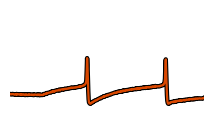

In [38]:
import matplotlib.patheffects as pe

fig = plt.figure(figsize=(2.5, 1.5))
_ = plt.plot(x_pred2.T, color=c,lw=1.6,path_effects=[pe.Stroke(linewidth=3.2, foreground='black'), pe.Normal()])
plt.ylim(-150, 150)
plt.xlim(0, 500)
plt.axis("off")
fig.savefig("x_tilde_pred2.svg", transparent=True)

In [39]:
from rbi.defenses import FIMTraceRegularizer
torch.manual_seed(seed)

model2 = InverseAffineAutoregressiveModel(task.input_dim, task.output_dim, output_transform=torch.distributions.biject_to(prior.support), num_transforms=3, embedding_net=nn.Sequential(nn.Linear(500,200), nn.ReLU(),nn.Linear(200, 200), nn.ReLU(), nn.Linear(200, 50), nn.ReLU()), hidden_dims=[100,100])
loss_fn2 = NLLLoss(model2)
defenses = FIMTraceRegularizer(model2, loss_fn2, algorithm="ema", beta=10., ema_mc_samples=10)
defenses.activate()

In [40]:
num_epochs = 40
optim = torch.optim.Adam(model2.parameters())
for i in range(num_epochs):
    for x, theta in train_loader:
        optim.zero_grad()
        l = loss_fn2(x, theta)
        l.backward()
        torch.nn.utils.clip_grad_norm_(model2.parameters(), 10.)
        optim.step()
    print(l)

tensor([8.9603], grad_fn=<AddBackward0>)
tensor([8.3705], grad_fn=<AddBackward0>)
tensor([7.9914], grad_fn=<AddBackward0>)
tensor([7.5746], grad_fn=<AddBackward0>)
tensor([7.2873], grad_fn=<AddBackward0>)
tensor([7.2409], grad_fn=<AddBackward0>)
tensor([6.3542], grad_fn=<AddBackward0>)
tensor([5.5602], grad_fn=<AddBackward0>)
tensor([6.0542], grad_fn=<AddBackward0>)
tensor([6.1989], grad_fn=<AddBackward0>)
tensor([6.1210], grad_fn=<AddBackward0>)
tensor([6.1130], grad_fn=<AddBackward0>)
tensor([6.2566], grad_fn=<AddBackward0>)
tensor([6.6662], grad_fn=<AddBackward0>)
tensor([7.3317], grad_fn=<AddBackward0>)
tensor([6.1083], grad_fn=<AddBackward0>)
tensor([6.6264], grad_fn=<AddBackward0>)
tensor([5.9187], grad_fn=<AddBackward0>)
tensor([5.8275], grad_fn=<AddBackward0>)
tensor([5.8637], grad_fn=<AddBackward0>)
tensor([5.6029], grad_fn=<AddBackward0>)
tensor([5.5560], grad_fn=<AddBackward0>)
tensor([5.3315], grad_fn=<AddBackward0>)
tensor([5.1212], grad_fn=<AddBackward0>)
tensor([5.1656],

In [41]:
attack = LinfPGDAdamAttack(model, ReverseKLLoss(mc_samples=5), eps=3., eps_iter=0.1, nb_iter=200)

In [42]:
x_o_tilde2 = attack.perturb(x_o)

In [43]:
q = model2(x_o)
samples = q.sample((50000,))

In [44]:
theta = thetas[x_idx[1]].unsqueeze(0)

C:\Users\manug\AppData\Local\Temp\ipykernel_10620\3893230416.py:18: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "bbox" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.savefig("rob_post.svg", bbox="tight", transparent=True)


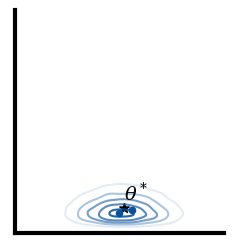

In [45]:
with use_style("pyloric"):
    mpl.rcParams["axes.linewidth"]=3
    fig, axes = custom_2d_joint_plot([samples.squeeze(),],dim1=0, dim2=1,figsize=(3.25,3.5), bins=200,ylim=[0,100], xlim=[20,35], labels=["$\\theta_1$", "$\\theta_2$"], colors=colors)
    sample1 = q.sample()
    sample2 = q.sample()
    axes[0].scatter(theta[:, 0], theta[:, 1],color="black", marker="*", s=50.)
    axes[0].text(theta[:, 0], theta[:, 1] + 3, "$\\theta^*$", fontsize=14)

    axes[0].scatter(sample1[:,0], sample1[:,1], s=20., color=colors[0])
    axes[0].scatter(sample2[:,0], sample2[:,1], s=20., color=colors[0])
    axes[0].set_xticks([])
    axes[0].set_yticks([])
    fig.delaxes(axes[1])
    fig.delaxes(axes[2])
    axes[0].set_ylabel("")
    axes[0].set_xlabel("")

fig.savefig("rob_post.svg", bbox="tight", transparent=True)

In [46]:
q = model2(x_o_tilde2)
samples = q.sample((50000,))

In [47]:
torch.manual_seed(seed+8)

In [48]:
sample1 = q.sample()
sample2 = q.sample()

In [49]:
x_pred1 = simulator(sample1)
x_pred2 = simulator(sample2)

C:\Users\manug\AppData\Local\Temp\ipykernel_10620\3548204906.py:16: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "bbox" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.savefig("rob_adversarial_post.svg", bbox="tight", transparent=True)


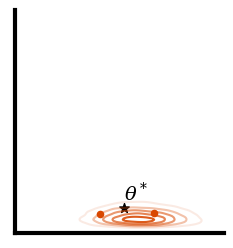

In [50]:
with use_style("pyloric"):
    mpl.rcParams["axes.linewidth"]=3
    fig, axes = custom_2d_joint_plot([samples.squeeze(),],dim1=0, dim2=1,figsize=(3.25,3.5), bins=200,ylim=[0,100], xlim=[20,35], labels=["$\\theta_1$", "$\\theta_2$"], colors=[c])
    axes[0].scatter(theta[:, 0], theta[:, 1],color="black", marker="*", s=50.)
    axes[0].text(theta[:, 0], theta[:, 1] + 3, "$\\theta^*$", fontsize=14)

    axes[0].scatter(sample1[:,0], sample1[:,1], s=20., color=c)
    axes[0].scatter(sample2[:,0], sample2[:,1], s=20., color=c)
    axes[0].set_xticks([])
    axes[0].set_yticks([])
    fig.delaxes(axes[1])
    fig.delaxes(axes[2])
    axes[0].set_ylabel("")
    axes[0].set_xlabel("")

fig.savefig("rob_adversarial_post.svg", bbox="tight", transparent=True)

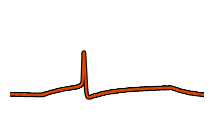

In [51]:
import matplotlib.patheffects as pe

fig = plt.figure(figsize=(2.5, 1.5))
_ = plt.plot(x_pred1.T, color=c,lw=1.6,path_effects=[pe.Stroke(linewidth=3.2, foreground='black'), pe.Normal()])
plt.ylim(-150, 150)
plt.xlim(0, 500)
plt.axis("off")
fig.savefig("rob_x_pred1.svg", transparent=True)

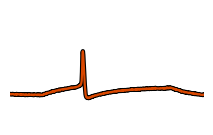

In [52]:
import matplotlib.patheffects as pe

fig = plt.figure(figsize=(2.5, 1.5))
_ = plt.plot(x_pred2.T, color=c,lw=1.6,path_effects=[pe.Stroke(linewidth=3.2, foreground='black'), pe.Normal()])
plt.ylim(-150, 150)
plt.xlim(0, 500)
plt.axis("off")
fig.savefig("rob_x_pred2.svg", transparent=True)

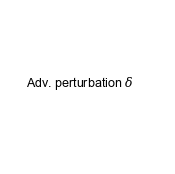

In [53]:
with use_style("pyloric"):
    fig = plt.figure(figsize=(2,2))
    plt.text(0.1,0.5, "Adv. perturbation $\\delta$", font="Arial")
    plt.axis("off")
fig.savefig("adversarial_pert_text.svg", transparent=True)

<Figure size 200x200 with 0 Axes>

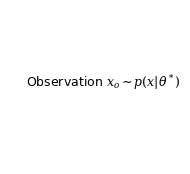

In [54]:
with use_style("pyloric"):
    fig = plt.figure(figsize=(2,2))
    fig = plt.figure(figsize=(2,2))
    plt.text(0.1,0.5, "Observation $x_o \\sim p(x|\\theta^*)$")
    plt.axis("off")
fig.savefig("x_o_text.svg", transparent=True)

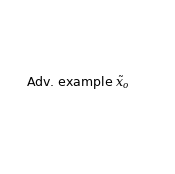

In [55]:

with use_style("pyloric"):
    fig = plt.figure(figsize=(2,2))
    plt.text(0.1,0.5, "Adv. example $\\tilde{x}_o$")
    plt.axis("off")
fig.savefig("x_tilde_text.svg", transparent=True)

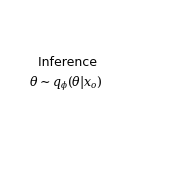

In [56]:

with use_style("pyloric"):
    fig = plt.figure(figsize=(2,2))
    plt.text(0.1,0.5, "   Inference\n $\\theta \\sim q_\\phi(\\theta|x_o)$", linespacing=1.5)
    plt.axis("off")
fig.savefig("inference.svg", transparent=True)

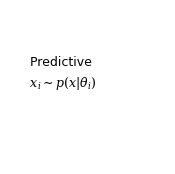

In [57]:

with use_style("pyloric"):
    fig = plt.figure(figsize=(2,2))
    plt.text(0.1,0.5, " Predictive\n $x_i \\sim p(x|\\theta_i)$", linespacing=1.5)
    plt.axis("off")
fig.savefig("predictive.svg", transparent=True)

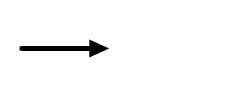

In [58]:
with use_style("pyloric"):
    fig = plt.figure(figsize=(3,1))
    plt.arrow(0.1, 0.5, 0.6,0, color="black", lw=3, head_width=.15, head_length=0.11)
    plt.xlim(0,2)
    plt.ylim(0,1)
    plt.axis("off")
    fig.savefig("arrow.svg", transparent=True)

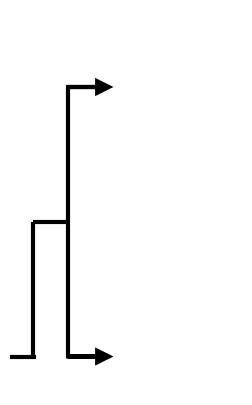

In [59]:
with use_style("pyloric"):
    fig = plt.figure(figsize=(3,5))
    plt.arrow(0.5, 8, 0.25,0, color="black", lw=3, head_width=.3, head_length=0.1)
    plt.arrow(0.5, 1, 0.25,0, color="black", lw=3, head_width=.3, head_length=0.1)
    plt.vlines(0.5,1,8, color="black", lw=3)
    plt.hlines(4.5,0.2,0.5, color="black", lw=3)
    plt.vlines(0.2,1,4.5, color="black", lw=3)
    plt.hlines(1,0.,0.22, color="black", lw=3)
    plt.xlim(0,2)
    plt.ylim(0,10)
    plt.axis("off")
    fig.savefig("strange_arrow.svg", transparent=True)